This notebook walks through the process of converting from images captured by the Raspberry Pi using the `--raw` command to useful numpy structures of the Bayer grid data.

This uses most of the example code from [the `picamera` module's section on Raw Bayer Captures](https://picamera.readthedocs.io/en/release-1.13/recipes2.html#raw-bayer-data-captures).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import io
import time
from numpy.lib.stride_tricks import as_strided

In [4]:
# load our pickled stream object containing the image data
import pickle
with open('wall2.pickle','rb') as f:
    stream = pickle.load(f)
# # alternatively, just open the jpeg file (also works)
# with open('wall1.jpeg', 'rb') as f:
#     stream = io.BytesIO(f.read())
assert isinstance(stream, io.BytesIO)
ver = 1  # we used a v1 camera module for this image. Use `2` for v2

In [5]:
# Extract the raw Bayer data from the end of the stream, check the
# header and strip if off before converting the data into a numpy array

offset = {
    1: 6404096,
    2: 10270208,
    }[ver]
data = stream.getvalue()[-offset:]
assert data[:4] == b'BRCM'
data = data[32768:]
data = np.frombuffer(data, dtype=np.uint8)

In [6]:
# For the V1 module, the data consists of 1952 rows of 3264 bytes of data.
# The last 8 rows of data are unused (they only exist because the maximum
# resolution of 1944 rows is rounded up to the nearest 16).
#
# For the V2 module, the data consists of 2480 rows of 4128 bytes of data.
# There's actually 2464 rows of data, but the sensor's raw size is 2466
# rows, rounded up to the nearest multiple of 16: 2480.
#
# Likewise, the last few bytes of each row are unused (why?). Here we
# reshape the data and strip off the unused bytes.

reshape, crop = {
    1: ((1952, 3264), (1944, 3240)),
    2: ((2480, 4128), (2464, 4100)),
    }[ver]
data = data.reshape(reshape)[:crop[0], :crop[1]]

In [7]:
# Horizontally, each row consists of 10-bit values. Every four bytes are
# the high 8-bits of four values, and the 5th byte contains the packed low
# 2-bits of the preceding four values. In other words, the bits of the
# values A, B, C, D and arranged like so:
#
#  byte 1   byte 2   byte 3   byte 4   byte 5
# AAAAAAAA BBBBBBBB CCCCCCCC DDDDDDDD AABBCCDD
#
# Here, we convert our data into a 16-bit array, shift all values left by
# 2-bits and unpack the low-order bits from every 5th byte in each row,
# then remove the columns containing the packed bits

data = data.astype(np.uint16) << 2
for byte in range(4):
    data[:, byte::5] |= ((data[:, 4::5] >> ((4 - byte) * 2)) & 0b11)
data = np.delete(data, np.s_[4::5], 1)

In [8]:
# Now to split the data up into its red, green, and blue components. The
# Bayer pattern of the OV5647 sensor is BGGR. In other words the first
# row contains alternating green/blue elements, the second row contains
# alternating red/green elements, and so on as illustrated below:
#
# GBGBGBGBGBGBGB
# RGRGRGRGRGRGRG
# GBGBGBGBGBGBGB
# RGRGRGRGRGRGRG
#
# Please note that if you use vflip or hflip to change the orientation
# of the capture, you must flip the Bayer pattern accordingly

rgb = np.zeros(data.shape + (3,), dtype=data.dtype)
rgb[1::2, 0::2, 0] = data[1::2, 0::2] # Red
rgb[0::2, 0::2, 1] = data[0::2, 0::2] # Green
rgb[1::2, 1::2, 1] = data[1::2, 1::2] # Green
rgb[0::2, 1::2, 2] = data[0::2, 1::2] # Blue

In [9]:
# At this point we now have the raw Bayer data with the correct values
# and colors but the data still requires de-mosaicing and
# post-processing. If you wish to do this yourself, end the script here!

In [10]:
rgb

array([[[  0, 145,   0],
        [  0,   0,  73],
        [  0, 121,   0],
        ...,
        [  0,   0,  79],
        [  0, 149,   0],
        [  0,   0,  72]],

       [[106,   0,   0],
        [  0, 145,   0],
        [104,   0,   0],
        ...,
        [  0, 138,   0],
        [115,   0,   0],
        [  0, 149,   0]],

       [[  0, 131,   0],
        [  0,   0,  66],
        [  0, 120,   0],
        ...,
        [  0,   0,  78],
        [  0, 156,   0],
        [  0,   0,  78]],

       ...,

       [[ 67,   0,   0],
        [  0,  74,   0],
        [ 65,   0,   0],
        ...,
        [  0, 140,   0],
        [130,   0,   0],
        [  0, 125,   0]],

       [[  0,  69,   0],
        [  0,   0,  37],
        [  0,  70,   0],
        ...,
        [  0,   0,  60],
        [  0, 136,   0],
        [  0,   0,  57]],

       [[ 62,   0,   0],
        [  0,  82,   0],
        [ 61,   0,   0],
        ...,
        [  0, 136,   0],
        [120,   0,   0],
        [  0, 142,   0]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


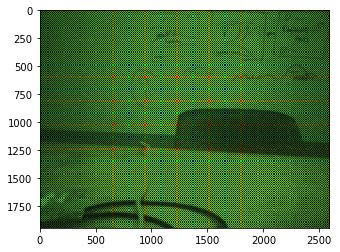

In [11]:
plt.imshow(rgb)

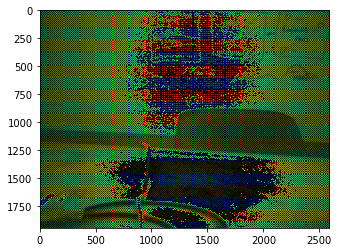

In [12]:
plt.imshow(rgb.astype(np.uint8))

That looks odd...

In [13]:
rgb[rgb > 255].astype(np.uint16)

array([258, 259, 257, ..., 258, 261, 258], dtype=uint16)

In [14]:
rgb[rgb > 255].astype(np.uint8)

array([2, 3, 1, ..., 2, 5, 2], dtype=uint8)

In [15]:
np.max(rgb.astype(np.uint8))

255

In [16]:
np.max(rgb)

415

ok, `astype` doesn't remap the values to the 0-255 range, it overflows...

In [17]:
np.max(rgb * 255/1023)  # remap from 10-bit to 8-bit range

64.06158357771261

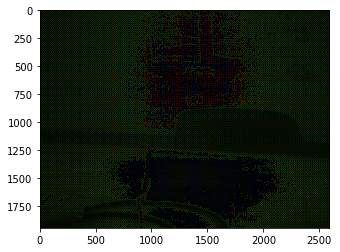

In [18]:
plt.imshow((rgb * 255/1023).astype(np.uint8))

still the odd artifacts...

In [19]:
np.max(rgb * 255)

65535

In [20]:
0b1111111111111111  # max value of uint16

65535

In [21]:
np.max(rgb * (255/1023))

103.44574780058652

In [22]:
np.max(rgb * 255/1023)

64.06158357771261

In [23]:
65535/1023

64.06158357771261

looks like the `*255` caused it to overflow _before_ converting to a float, while multiplying it by the fraction `(255/1023)` converts it to a float initially.

In [24]:
uint16_to_uint8 = lambda a: (a * (255/1023)).astype(np.uint8)  # note, this only works b/c the values are actually 10-bit
# uint16_to_uint8 = lambda a: (a >> 2).astype(np.uint8)  # or bit-shift as suggested at the end
rgb8 = uint16_to_uint8(rgb)
np.max(rgb8)

103

In [25]:
assert rgb8.dtype == np.uint8

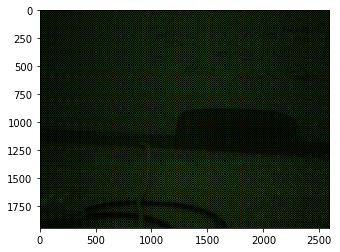

In [26]:
plt.imshow(rgb8)

that looks much more expected

In [27]:
im = Image.fromarray(rgb8)

In [28]:
im.save('mosaic_rgb.png')  # save mosaiced image in color

now for black and white, we can just collapse the 3-dimensional array by summing the RGB values (since only one of the three will have a value for any given entry)

In [29]:
np.sum(rgb8,axis=2).shape  # make sure I'm collapsing the right axis

(1944, 2592)

In [30]:
assert np.max(np.sum(rgb8, axis=2)) < 255  # sum returns uint64, I'm making sure here that it won't overflow somehow

In [31]:
imbw = Image.fromarray(np.sum(rgb8, axis=2).astype(np.uint8))

In [32]:
imbw.save('mosaic_bw.png')

In [33]:
# Below we present a fairly naive de-mosaic method that simply
# calculates the weighted average of a pixel based on the pixels
# surrounding it. The weighting is provided by a byte representation of
# the Bayer filter which we construct first:

bayer = np.zeros(rgb.shape, dtype=np.uint8)
bayer[1::2, 0::2, 0] = 1 # Red
bayer[0::2, 0::2, 1] = 1 # Green
bayer[1::2, 1::2, 1] = 1 # Green
bayer[0::2, 1::2, 2] = 1 # Blue

# Allocate an array to hold our output with the same shape as the input
# data. After this we define the size of window that will be used to
# calculate each weighted average (3x3). Then we pad out the rgb and
# bayer arrays, adding blank pixels at their edges to compensate for the
# size of the window when calculating averages for edge pixels.

output = np.empty(rgb.shape, dtype=rgb.dtype)
window = (3, 3)
borders = (window[0] - 1, window[1] - 1)
border = (borders[0] // 2, borders[1] // 2)

rgb_padded = np.pad(rgb, [
    (border[0], border[0]),
    (border[1], border[1]),
    (0, 0),
    ], 'constant')
bayer = np.pad(bayer, [
    (border[0], border[0]),
    (border[1], border[1]),
    (0, 0),
    ], 'constant')

# For each plane in the RGB data, we use a nifty numpy trick
# (as_strided) to construct a view over the plane of 3x3 matrices. We do
# the same for the bayer array, then use Einstein summation on each
# (np.sum is simpler, but copies the data so it's slower), and divide
# the results to get our weighted average:

for plane in range(3):
    p = rgb_padded[..., plane]
    b = bayer[..., plane]
    pview = as_strided(p, shape=(
        p.shape[0] - borders[0],
        p.shape[1] - borders[1]) + window, strides=p.strides * 2)
    bview = as_strided(b, shape=(
        b.shape[0] - borders[0],
        b.shape[1] - borders[1]) + window, strides=b.strides * 2)
    psum = np.einsum('ijkl->ij', pview)
    bsum = np.einsum('ijkl->ij', bview)
    output[..., plane] = psum // bsum

# At this point output should contain a reasonably "normal" looking
# image, although it still won't look as good as the camera's normal
# output (as it lacks vignette compensation, AWB, etc).
#
# If you want to view this in most packages (like GIMP) you'll need to
# convert it to 8-bit RGB data. The simplest way to do this is by
# right-shifting everything by 2-bits (yes, this makes all that
# unpacking work at the start rather redundant...)

output = (output >> 2).astype(np.uint8)
with open('image.data', 'wb') as f:
    output.tofile(f)

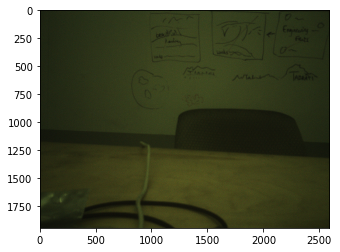

In [34]:
plt.imshow(output)

In [ ]:
Image.fromarray(output).save('demosaiced.png')

In [35]:
# alternatively, convolution?
from scipy.signal import convolve
bayer = np.zeros(rgb.shape, dtype=np.uint8)
bayer[1::2, 0::2, 0] = 1 # Red
bayer[0::2, 0::2, 1] = 1 # Green
bayer[1::2, 1::2, 1] = 1 # Green
bayer[0::2, 1::2, 2] = 1 # Blue

In [36]:
Image.fromarray(rgb8[:,:,0]).save('red.png')

In [37]:
Image.fromarray(rgb8[:,:,1]).save('green.png')

In [38]:
Image.fromarray(rgb8[:,:,2]).save('blue.png')

In [39]:
r = convolve(bayer[:,:,0],rgb8[:,:,0]*0.5)

In [42]:
r.shape

(3887, 5183)

In [40]:
np.max(r)

29592997.5

In [41]:
# res = np.zeros(rgb8.shape, dtype=np.uint8)
# for i in range(3):
#     res[::,::,i] = convolve()

TypeError: convolve() missing 2 required positional arguments: 'in1' and 'in2'

I'm having difficulty thinking of a way to make this work without restructuring the original rgb array or doing funky summation/boolean filtering.
The closest I've gotten is convolving across each r/g/b plane and dividing by the sum of `[[1,1,1],[1,1,1],[1,1,1]]` of `bayer`.

In [45]:
kernel = np.ones((3,3),dtype=np.uint8)
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [53]:
bayer_conv = np.zeros(bayer.shape, dtype=np.uint8)
for i in range(3):
    bayer_conv[:,:,i] = convolve(bayer[:,:,i], kernel, mode='same')
bayer_conv[:3,:3,0]  # peek at top left corner of r plane

array([[1, 2, 1],
       [1, 2, 1],
       [2, 4, 2]], dtype=uint8)

this is pretty much minesweeper where r, g, and b are mines

In [60]:
np.array([['','','','',''],['','g','b','g','b'],['','r','g','r','g'],['','g','b','g','b']], dtype=str)  # top left corner of bayer array

array([['', '', '', '', ''],
       ['', 'g', 'b', 'g', 'b'],
       ['', 'r', 'g', 'r', 'g'],
       ['', 'g', 'b', 'g', 'b']], dtype='<U1')

In [96]:
rgb8_conv = np.zeros(rgb8.shape, dtype=np.uint16)  # max sum here should be 1275 for 5 maxed green sencels
for i in range(3):
    rgb8_conv[:,:,i] = convolve(rgb8[:,:,i].astype(np.uint16), kernel, mode='same')

In [97]:
np.max(rgb8_conv)

504

In [98]:
res = rgb8_conv / bayer_conv

In [99]:
res.shape

(1944, 2592, 3)

In [100]:
np.max(res)

101.75

In [101]:
res = res.astype(np.uint8)

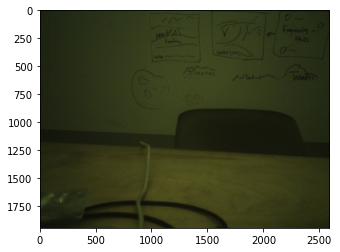

In [102]:
plt.imshow(res)

In [103]:
Image.fromarray(res).save('demosaiced_convolution.png')